# Iterative Agent-Based Feature Selection for Financial Time Series

This notebook implements an iterative process that:
1. Runs a baseline model without enhanced features
2. Uses an AI agent to generate feature engineering code
3. Tests the enhanced features and measures performance
4. Iteratively improves the features based on performance feedback
5. Continues until performance plateaus

The system combines the robust feature selection from `05_Agent_selecting.ipynb` with the iterative improvement process from `test.py`.


In [15]:
# Import all necessary libraries
import pickle
import anthropic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import warnings
import time
from datetime import datetime
import json
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [ ]:
# Load data and configuration
stock = 'PFE'
ANTHROPIC_API_KEY = ''  # Replace with your actual API key

# Load raw data
raw_data = pickle.load(open(f'cache/{stock}_raw_data_with_ohlc.pkl', 'rb'))
X_train_raw = raw_data['X_train_raw']
X_test_raw = raw_data['X_test_raw']
y_train = raw_data['y_train']
y_test = raw_data['y_test']
prev_log_train = raw_data['prev_log_train']
prev_log_test = raw_data['prev_log_test']
si_dates = raw_data['si_dates']
SI_series = raw_data['SI_series']

print(f"✅ Data loaded successfully!")
print(f"Training data shape: {X_train_raw.shape}")
print(f"Test data shape: {X_test_raw.shape}")
print(f"Features per timestep: {X_train_raw.shape[2]}")
print(f"Lookback window: {X_train_raw.shape[1]}")


✅ Data loaded successfully!
Training data shape: (142, 4, 62)
Test data shape: (36, 4, 62)
Features per timestep: 62
Lookback window: 4


In [17]:
# Define the LSTM model class
class EnhancedLSTMTimeSeries(nn.Module):
    def __init__(self, input_size=62, hidden_size=64, num_layers=3, output_size=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Take the last time step output
        last_output = lstm_out[:, -1, :]
        
        # Feed through fully connected layers
        out = self.dropout(last_output)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

print("✅ LSTM model class defined!")


✅ LSTM model class defined!


In [18]:
# Function to calculate p-values for feature importance
def calculate_feature_pvalues(X_train, y_train, feature_names=None):
    """
    Calculate p-values for each feature using linear regression
    """
    from sklearn.linear_model import LinearRegression
    from scipy import stats
    
    # Flatten the 3D data to 2D for statistical analysis
    X_flat = X_train.reshape(X_train.shape[0], -1)
    y_flat = y_train.ravel()
    
    # Fit linear regression
    lr = LinearRegression()
    lr.fit(X_flat, y_flat)
    
    # Calculate residuals
    y_pred = lr.predict(X_flat)
    residuals = y_flat - y_pred
    mse = np.mean(residuals**2)
    
    # Calculate standard errors and t-statistics
    X_with_intercept = np.column_stack([np.ones(X_flat.shape[0]), X_flat])
    try:
        # Calculate covariance matrix
        cov_matrix = mse * np.linalg.inv(X_with_intercept.T @ X_with_intercept)
        standard_errors = np.sqrt(np.diag(cov_matrix))[1:]  # Exclude intercept
        t_statistics = lr.coef_ / standard_errors
        
        # Calculate p-values (two-tailed test)
        degrees_of_freedom = X_flat.shape[0] - X_flat.shape[1] - 1
        p_values = 2 * (1 - stats.t.cdf(np.abs(t_statistics), degrees_of_freedom))
        
    except np.linalg.LinAlgError:
        # If matrix is singular, use a simpler approach
        print("⚠️ Singular matrix detected, using simplified p-value calculation")
        p_values = np.ones(X_flat.shape[1]) * 0.5  # Default to non-significant
    
    # Create feature names if not provided
    if feature_names is None:
        feature_names = [f"Feature_{i}" for i in range(X_flat.shape[1])]
    
    # Create results dictionary
    feature_stats = {}
    for i, (name, pval, coef) in enumerate(zip(feature_names, p_values, lr.coef_)):
        feature_stats[name] = {
            'p_value': pval,
            'coefficient': coef,
            'significant': pval < 0.05,
            'highly_significant': pval < 0.01
        }
    
    return feature_stats, lr.coef_, p_values

# Enhanced function to train and evaluate a model with p-value analysis
def train_and_evaluate_model(X_train, X_test, y_train, y_test, prev_log_test, model_name="Model", epochs=50):
    """
    Train and evaluate an LSTM model, returning performance metrics and feature statistics
    """
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")
    
    # Scale inputs
    scaler = StandardScaler()
    X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
    scaler.fit(X_train_reshaped)
    
    X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train.shape)
    X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
    X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)
    
    # Convert to tensors
    X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32)
    
    # Create data loaders
    batch_size = 8
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=batch_size)
    
    # Initialize model
    model = EnhancedLSTMTimeSeries(input_size=X_train.shape[-1], hidden_size=32, num_layers=2, output_size=1)
    criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    
    # Training loop
    best_loss = float('inf')
    patience = 10
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        # Early stopping
        if train_loss < best_loss:
            best_loss = train_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Evaluation
    model.eval()
    pred_logret = []
    with torch.no_grad():
        for xb, _ in test_loader:
            pred_logret.append(model(xb).numpy())
    pred_logret = np.concatenate(pred_logret, axis=0).ravel()
    
    # Reconstruct levels
    y_pred_levels = np.exp(prev_log_test + pred_logret)
    y_true_levels = np.exp(prev_log_test + y_test.ravel())
    
    # Calculate metrics
    mae = np.mean(np.abs(y_pred_levels - y_true_levels))
    rmse = np.sqrt(np.mean((y_pred_levels - y_true_levels)**2))
    mape = np.mean(np.abs((y_true_levels - y_pred_levels) / y_true_levels)) * 100
    
    print(f"\n{model_name} Performance:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    # Calculate feature p-values
    print(f"\n📊 Calculating feature p-values...")
    feature_names = [f"Feature_{i}" for i in range(X_train.shape[-1])]
    feature_stats, coefficients, p_values = calculate_feature_pvalues(X_train_scaled, y_train, feature_names)
    
    # Print feature significance summary
    significant_features = [name for name, stats in feature_stats.items() if stats['significant']]
    highly_significant = [name for name, stats in feature_stats.items() if stats['highly_significant']]
    
    print(f"📈 Feature Significance Analysis:")
    print(f"   • Total features: {len(feature_stats)}")
    print(f"   • Significant features (p < 0.05): {len(significant_features)}")
    print(f"   • Highly significant features (p < 0.01): {len(highly_significant)}")
    
    if significant_features:
        print(f"   • Significant features: {significant_features[:5]}{'...' if len(significant_features) > 5 else ''}")
    
    return {
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'predictions': y_pred_levels,
        'true_values': y_true_levels,
        'model': model,
        'scaler': scaler,
        'feature_stats': feature_stats,
        'coefficients': coefficients,
        'p_values': p_values,
        'significant_features': significant_features,
        'highly_significant_features': highly_significant
    }

print("✅ Model training and evaluation function defined!")


✅ Model training and evaluation function defined!


In [6]:
# Step 1: Run baseline model with all original features
print("🚀 Starting Iterative Agent-Based Feature Selection Process")
print("="*70)

# Baseline model with all 62 features
baseline_results = train_and_evaluate_model(
    X_train_raw, X_test_raw, y_train, y_test, prev_log_test, 
    model_name="Baseline (All 62 Features)", epochs=50
)

baseline_mape = baseline_results['mape']
print(f"\n📊 Baseline Performance: MAPE = {baseline_mape:.2f}%")

# Store results for comparison
iteration_results = []
iteration_results.append({
    'iteration': 0,
    'model_name': 'Baseline',
    'features_used': 'All 62 original features',
    'feature_count': X_train_raw.shape[2],
    'mape': baseline_mape,
    'mae': baseline_results['mae'],
    'rmse': baseline_results['rmse'],
    'improvement': 0.0,
    'predictions': baseline_results['predictions']
})

print("✅ Baseline model completed!")


🚀 Starting Iterative Agent-Based Feature Selection Process

Training Baseline (All 62 Features)
Epoch 1/50, Train Loss: 0.026222
Epoch 11/50, Train Loss: 0.014758
Epoch 21/50, Train Loss: 0.013826
Epoch 31/50, Train Loss: 0.012481
Epoch 41/50, Train Loss: 0.011918

Baseline (All 62 Features) Performance:
MAE: 7301369.5718
RMSE: 9576693.4427
MAPE: 9.37%

📊 Baseline Performance: MAPE = 9.37%
✅ Baseline model completed!


In [20]:
# Define the LLM Feature Selector class (adapted from test.py)
class IterativeLLMFeatureSelector:
    """
    An iterative LLM-based feature selector that learns from previous iterations
    """
    
    def __init__(self, anthropic_api_key: str):
        self.client = anthropic.Anthropic(api_key=anthropic_api_key)
        self.iteration_history = []
        print("✅ Claude API client initialized successfully!")
    
    def create_iterative_prompt(self, iteration_num: int, previous_results: list, feature_description: str) -> str:
        """
        Create a prompt that includes performance history and asks for improvements
        """
        # Build performance history
        history_text = ""
        if previous_results:
            history_text = "\n\nPERFORMANCE HISTORY:\n"
            for i, result in enumerate(previous_results):
                history_text += f"Iteration {i}: {result['model_name']} - MAPE: {result['mape']:.2f}%"
                if i > 0:
                    improvement = result['improvement']
                    history_text += f" (Improvement: {improvement:+.1f}%)"
                history_text += f"\n  Features: {result['features_used']}\n"
        
        # Get the best performance so far
        best_mape = min([r['mape'] for r in previous_results]) if previous_results else 100.0
        
        prompt = f"""
You are a financial data scientist expert in feature engineering for Short Interest prediction models. 

I have financial time series data with the following structure:
- Shape: (samples, lookback_window=4, features=62)
- Features at each timestamp T include:
  1. Short interest at time T reproted every 15 days (1 feature)
  2. Average daily volume quantity of past 15 days (1 feature) 
  3. OHLC (Open, High, Low, Close) prices for past 15 days (4 × 15 = 60 features)

Total: 1 + 1 + 60 = 62 features per timestamp.

{history_text}

CURRENT TASK (Iteration {iteration_num}):
Your goal is to create an improved feature engineering function that will achieve better performance than the current best MAPE of {best_mape:.2f}%.

Based on the performance history above, analyze what worked and what didn't, then create a new feature engineering approach that:
1. Learns from previous iterations' successes and failures
2. Focuses on the most predictive features
3. Considers financial domain knowledge (momentum, volatility, volume patterns, etc.)
4. Maintains LSTM-compatible time series structure

Requirements:
1. Write a function called `construct_features` that takes a numpy array of shape (lookback_window, 62) and returns a numpy array of shape (lookback_window, constructed_features)
2. The function should process each timestamp independently but maintain the temporal structure
3. Focus on the most predictive features for each time step
4. Consider financial domain knowledge (e.g., price momentum, volatility, volume patterns, etc.)
5. The output should be a 2D numpy array with shape (lookback_window, constructed_features)
6. Include comments explaining your feature engineering choices and how they address previous performance issues
7. Make sure the code is production-ready and handles edge cases
8. DO NOT include any import statements - only use numpy (available as 'np') and built-in Python functions
9. The function must return a 2D array where each row represents features for one time step
10. Use numpy nan_to_num to handle NaN values

Please provide ONLY the Python function code, no explanations outside the code comments.

Feature description: {feature_description}
"""
        return prompt
    
    def call_claude_for_iterative_improvement(self, iteration_num: int, previous_results: list, feature_description: str = "Stock prediction with short interest, volume, and OHLC data") -> str:
        """
        Call Claude API with iterative improvement context
        """
        prompt = self.create_iterative_prompt(iteration_num, previous_results, feature_description)
        
        try:
            response = self.client.messages.create(
                model="claude-3-5-sonnet-20241022",
                max_tokens=2000,
                temperature=0.1,  # Slightly higher temperature for creativity in later iterations
                messages=[
                    {"role": "user", "content": prompt}
                ]
            )
            
            return response.content[0].text
        except Exception as e:
            print(f"Error calling Claude API: {e}")
            return None
    
    def extract_function_from_response(self, response_text: str) -> str:
        """
        Extract the construct_features function from Claude's response
        """
        lines = response_text.split('\n')
        function_lines = []
        in_function = False
        indent_level = 0
        
        for line in lines:
            if 'def construct_features' in line:
                in_function = True
                function_lines.append(line)
                indent_level = len(line) - len(line.lstrip())
            elif in_function:
                if line.strip() == '':
                    function_lines.append(line)
                elif len(line) - len(line.lstrip()) > indent_level or line.strip() == '':
                    function_lines.append(line)
                else:
                    break
        
        return '\n'.join(function_lines)
    
    def execute_feature_construction_code(self, code: str) -> callable:
        """
        Execute the generated feature construction code and return the function
        """
        try:
            exec_globals = {
                'np': np,
                'pd': pd,
                '__builtins__': {
                    'len': len, 'range': range, 'enumerate': enumerate, 'zip': zip,
                    'sum': sum, 'max': max, 'min': min, 'abs': abs, 'round': round,
                    'int': int, 'float': float, 'str': str, 'list': list, 'dict': dict,
                    'tuple': tuple, 'set': set, 'print': print, 'any': any, 'all': all,
                    'sorted': sorted, 'reversed': reversed, 'isinstance': isinstance,
                    'type': type, 'hasattr': hasattr, 'getattr': getattr, 'setattr': setattr,
                    'callable': callable, 'issubclass': issubclass, 'super': super,
                    'open': open, 'iter': iter, 'next': next, 'map': map, 'filter': filter,
                    'pow': pow, 'divmod': divmod, 'bin': bin, 'hex': hex, 'oct': oct,
                    'ord': ord, 'chr': chr, 'bool': bool, 'complex': complex,
                    'bytes': bytes, 'bytearray': bytearray, 'memoryview': memoryview,
                    'slice': slice, 'property': property, 'staticmethod': staticmethod,
                    'classmethod': classmethod,
                }
            }
            
            exec(code, exec_globals)
            
            if 'construct_features' in exec_globals:
                return exec_globals['construct_features']
            else:
                raise ValueError("construct_features function not found in generated code")
                
        except Exception as e:
            print(f"Error executing generated code: {e}")
            return None
    
    def fallback_construct_features(self, data: np.ndarray) -> np.ndarray:
        """
        Fallback feature construction function
        """
        if data.shape[1] != 62:
            raise ValueError(f"Expected 62 features, got {data.shape[1]}")
        
        lookback_window = data.shape[0]
        features_per_timestep = 15
        
        output = np.zeros((lookback_window, features_per_timestep))
        
        for t in range(lookback_window):
            short_interest = data[t, 0]
            volume = data[t, 1]
            ohlc = data[t, 2:].reshape(15, 4)
            
            # Basic features
            output[t, 0] = short_interest
            output[t, 1] = volume
            output[t, 2:6] = ohlc[-1]  # Latest OHLC
            
            # Momentum features
            close_prices = ohlc[:, 3]
            for i, horizon in enumerate([1, 3, 5, 10]):
                if len(close_prices) > horizon:
                    momentum = (close_prices[-1] - close_prices[-horizon-1]) / close_prices[-horizon-1]
                    output[t, 6 + i] = momentum
                else:
                    output[t, 6 + i] = 0
            
            # Volatility and range
            if len(close_prices) > 1:
                returns = np.diff(close_prices) / close_prices[:-1]
                output[t, 10] = np.std(returns)
                output[t, 11] = (np.max(close_prices) - np.min(close_prices)) / np.mean(close_prices)
            
            # Technical indicators
            if len(close_prices) > 1:
                sma_5 = np.mean(close_prices[-5:]) if len(close_prices) >= 5 else np.mean(close_prices)
                output[t, 12] = close_prices[-1] / sma_5
                
                high_low_ratio = ohlc[:, 1] / ohlc[:, 2]
                output[t, 13] = np.mean(high_low_ratio)
                
                output[t, 14] = volume * close_prices[-1] / np.mean(close_prices)
        
        return output.astype(np.float32)
    
    def apply_feature_selection_to_data(self, X_data: np.ndarray, construct_func: callable, max_retries: int = 5) -> np.ndarray:
        """
        Apply feature selection to the entire dataset with retry mechanism
        """
        processed_samples = []
        retry_count = 0
        
        while retry_count < max_retries:
            try:
                processed_samples = []
                success = True
                
                for i in range(X_data.shape[0]):
                    sample_features = X_data[i]
                    
                    try:
                        reduced_features = construct_func(sample_features)
                        
                        if reduced_features.ndim == 1:
                            # Reshape 1D to 2D
                            features_per_step = len(reduced_features) // sample_features.shape[0]
                            if features_per_step > 0:
                                reduced_features = reduced_features[:features_per_step * sample_features.shape[0]]
                                reduced_features = reduced_features.reshape(sample_features.shape[0], features_per_step)
                            else:
                                reduced_features = np.zeros((sample_features.shape[0], 1))
                                reduced_features[0, 0] = reduced_features.mean() if len(reduced_features) > 0 else 0
                        
                        processed_samples.append(reduced_features)
                        
                    except Exception as e:
                        print(f"Error processing sample {i} in attempt {retry_count + 1}: {e}")
                        fallback_features = sample_features[:, :10] if sample_features.shape[1] >= 10 else sample_features
                        processed_samples.append(fallback_features)
                
                # If we get here, the function executed successfully
                print(f"✅ Feature selection applied successfully on attempt {retry_count + 1}")
                return np.array(processed_samples)
                
            except Exception as e:
                retry_count += 1
                print(f"❌ Attempt {retry_count} failed with error: {e}")
                if retry_count < max_retries:
                    print(f"🔄 Retrying... ({retry_count}/{max_retries})")
                else:
                    print(f"⚠️ All {max_retries} attempts failed, using fallback function")
                    # Use fallback function as last resort
                    return self._apply_fallback_feature_selection(X_data)
        
        return np.array(processed_samples)
    
    def _apply_fallback_feature_selection(self, X_data: np.ndarray) -> np.ndarray:
        """
        Fallback feature selection when all retries fail
        """
        print("🆘 Using fallback feature selection...")
        processed_samples = []
        
        for i in range(X_data.shape[0]):
            sample_features = X_data[i]
            # Simple fallback: take first 15 features from each timestep
            fallback_features = sample_features[:, :15] if sample_features.shape[1] >= 15 else sample_features
            processed_samples.append(fallback_features)
        
        return np.array(processed_samples)

print("✅ Iterative LLM Feature Selector class defined!")


✅ Iterative LLM Feature Selector class defined!


In [21]:
# Enhanced IterativeLLMFeatureSelector with p-value analysis
class EnhancedIterativeLLMFeatureSelector(IterativeLLMFeatureSelector):
    """
    Enhanced version with p-value analysis and improved prompts
    """
    
    def create_iterative_prompt(self, iteration_num: int, previous_results: list, feature_description: str) -> str:
        """
        Create a prompt that includes performance history, p-value analysis, and asks for improvements
        """
        # Build performance history with p-value information
        history_text = ""
        if previous_results:
            history_text = "\n\nPERFORMANCE HISTORY:\n"
            for i, result in enumerate(previous_results):
                history_text += f"Iteration {i}: {result['model_name']} - MAPE: {result['mape']:.2f}%"
                if i > 0:
                    improvement = result['improvement']
                    history_text += f" (Improvement: {improvement:+.1f}%)"
                history_text += f"\n  Features: {result['features_used']}\n"
                
                # Add p-value analysis if available
                if 'feature_stats' in result and result['feature_stats']:
                    significant_count = len(result.get('significant_features', []))
                    highly_significant_count = len(result.get('highly_significant_features', []))
                    total_features = len(result['feature_stats'])
                    
                    history_text += f"  Statistical Analysis:\n"
                    history_text += f"    • Total features: {total_features}\n"
                    history_text += f"    • Significant features (p < 0.05): {significant_count}\n"
                    history_text += f"    • Highly significant features (p < 0.01): {highly_significant_count}\n"
                    
                    # Add top significant features
                    if result.get('significant_features'):
                        top_significant = result['significant_features'][:3]
                        history_text += f"    • Top significant features: {', '.join(top_significant)}\n"
                    
                    # Add feature with lowest p-value
                    if result['feature_stats']:
                        min_pval_feature = min(result['feature_stats'].items(), key=lambda x: x[1]['p_value'])
                        history_text += f"    • Most significant feature: {min_pval_feature[0]} (p={min_pval_feature[1]['p_value']:.4f})\n"
                
                history_text += "\n"
        
        # Get the best performance so far
        best_mape = min([r['mape'] for r in previous_results]) if previous_results else 100.0
        
        # Get statistical insights from the best performing model
        best_result = min(previous_results, key=lambda x: x['mape']) if previous_results else None
        statistical_insights = ""
        
        if best_result and 'feature_stats' in best_result:
            statistical_insights = f"""
STATISTICAL INSIGHTS FROM BEST MODEL (MAPE: {best_result['mape']:.2f}%):
- Most predictive features (lowest p-values): {', '.join([f"{name} (p={stats['p_value']:.4f})" for name, stats in sorted(best_result['feature_stats'].items(), key=lambda x: x[1]['p_value'])[:5]])}
- Least predictive features (highest p-values): {', '.join([f"{name} (p={stats['p_value']:.4f})" for name, stats in sorted(best_result['feature_stats'].items(), key=lambda x: x[1]['p_value'], reverse=True)[:3]])}
- Feature significance ratio: {len(best_result.get('significant_features', []))}/{len(best_result['feature_stats'])} features are statistically significant
"""
        
        prompt = f"""
You are a financial data scientist expert in feature engineering for stock prediction models. 

I have financial time series data with the following structure:
- Shape: (samples, lookback_window=4, features=62)
- Features at each timestamp T include:
  1. Short interest at time T (1 feature)
  2. Average daily volume quantity of past 15 days (1 feature) 
  3. OHLC (Open, High, Low, Close) prices for past 15 days (4 × 15 = 60 features)

Total: 1 + 1 + 60 = 62 features per timestamp.

{history_text}

{statistical_insights}

CURRENT TASK (Iteration {iteration_num}):
Your goal is to create an improved feature engineering function that will achieve better performance than the current best MAPE of {best_mape:.2f}%.

Based on the performance history and statistical analysis above, analyze what worked and what didn't, then create a new feature engineering approach that:
1. Learns from previous iterations' successes and failures
2. Focuses on the most statistically significant and predictive features
3. Considers financial domain knowledge (momentum, volatility, volume patterns, etc.)
4. Maintains LSTM-compatible time series structure
5. Uses p-value insights to prioritize feature construction

Requirements:
1. Write a function called `construct_features` that takes a numpy array of shape (lookback_window, 62) and returns a numpy array of shape (lookback_window, constructed_features)
2. The function should process each timestamp independently but maintain the temporal structure
3. Focus on the most predictive features for each time step, using statistical significance as guidance
4. Consider financial domain knowledge (e.g., price momentum, volatility, volume patterns, etc.)
5. The output should be a 2D numpy array with shape (lookback_window, constructed_features)
6. Include comments explaining your feature engineering choices and how they address previous performance issues and statistical insights
7. Make sure the code is production-ready and handles edge cases
8. DO NOT include any import statements - only use numpy (available as 'np') and built-in Python functions
9. The function must return a 2D array where each row represents features for one time step
10. Use numpy nan_to_num to handle NaN values

Please provide ONLY the Python function code, no explanations outside the code comments.

Feature description: {feature_description}
"""
        return prompt

print("✅ Enhanced IterativeLLMFeatureSelector with p-value analysis defined!")


✅ Enhanced IterativeLLMFeatureSelector with p-value analysis defined!


In [22]:
# Define the LLM Feature Selector class (adapted from test.py)
class IterativeLLMFeatureSelector:
    """
    An iterative LLM-based feature selector that learns from previous iterations
    """
    
    def __init__(self, anthropic_api_key: str):
        self.client = anthropic.Anthropic(api_key=anthropic_api_key)
        self.iteration_history = []
        print("✅ Claude API client initialized successfully!")
    
    def create_iterative_prompt(self, iteration_num: int, previous_results: list, feature_description: str) -> str:
        """
        Create a prompt that includes performance history and asks for improvements
        """
        # Build performance history
        history_text = ""
        if previous_results:
            history_text = "\n\nPERFORMANCE HISTORY:\n"
            for i, result in enumerate(previous_results):
                history_text += f"Iteration {i}: {result['model_name']} - MAPE: {result['mape']:.2f}%"
                if i > 0:
                    improvement = result['improvement']
                    history_text += f" (Improvement: {improvement:+.1f}%)"
                history_text += f"\n  Features: {result['features_used']}\n"
        
        # Get the best performance so far
        best_mape = min([r['mape'] for r in previous_results]) if previous_results else 100.0
        
        prompt = f"""
You are a financial data scientist expert in feature engineering for Short Interest prediction models. 

I have financial time series data with the following structure:
- Shape: (samples, lookback_window=4, features=62)
- Features at each timestamp T include:
  1. Short interest at time T reproted every 15 days (1 feature)
  2. Average daily volume quantity of past 15 days (1 feature) 
  3. OHLC (Open, High, Low, Close) prices for past 15 days (4 × 15 = 60 features)

Total: 1 + 1 + 60 = 62 features per timestamp.

{history_text}

CURRENT TASK (Iteration {iteration_num}):
Your goal is to create an improved feature engineering function that will achieve better performance than the current best MAPE of {best_mape:.2f}%.

Based on the performance history above, analyze what worked and what didn't, then create a new feature engineering approach that:
1. Learns from previous iterations' successes and failures
2. Focuses on the most predictive features
3. Considers financial domain knowledge (momentum, volatility, volume patterns, etc.)
4. Maintains LSTM-compatible time series structure

Requirements:
1. Write a function called `construct_features` that takes a numpy array of shape (lookback_window, 62) and returns a numpy array of shape (lookback_window, constructed_features)
2. The function should process each timestamp independently but maintain the temporal structure
3. Focus on the most predictive features for each time step
4. Consider financial domain knowledge (e.g., price momentum, volatility, volume patterns, etc.)
5. The output should be a 2D numpy array with shape (lookback_window, constructed_features)
6. Include comments explaining your feature engineering choices and how they address previous performance issues
7. Make sure the code is production-ready and handles edge cases
8. DO NOT include any import statements - only use numpy (available as 'np') and built-in Python functions
9. The function must return a 2D array where each row represents features for one time step
10. Use numpy nan_to_num to handle NaN values

Please provide ONLY the Python function code, no explanations outside the code comments.

Feature description: {feature_description}
"""
        return prompt
    
    def call_claude_for_iterative_improvement(self, iteration_num: int, previous_results: list, feature_description: str = "Stock prediction with short interest, volume, and OHLC data") -> str:
        """
        Call Claude API with iterative improvement context
        """
        prompt = self.create_iterative_prompt(iteration_num, previous_results, feature_description)
        
        try:
            response = self.client.messages.create(
                model="claude-3-5-sonnet-20241022",
                max_tokens=2000,
                temperature=0.1,  # Slightly higher temperature for creativity in later iterations
                messages=[
                    {"role": "user", "content": prompt}
                ]
            )
            
            return response.content[0].text
        except Exception as e:
            print(f"Error calling Claude API: {e}")
            return None
    
    def extract_function_from_response(self, response_text: str) -> str:
        """
        Extract the construct_features function from Claude's response
        """
        lines = response_text.split('\n')
        function_lines = []
        in_function = False
        indent_level = 0
        
        for line in lines:
            if 'def construct_features' in line:
                in_function = True
                function_lines.append(line)
                indent_level = len(line) - len(line.lstrip())
            elif in_function:
                if line.strip() == '':
                    function_lines.append(line)
                elif len(line) - len(line.lstrip()) > indent_level or line.strip() == '':
                    function_lines.append(line)
                else:
                    break
        
        return '\n'.join(function_lines)
    
    def execute_feature_construction_code(self, code: str) -> callable:
        """
        Execute the generated feature construction code and return the function
        """
        try:
            exec_globals = {
                'np': np,
                'pd': pd,
                '__builtins__': {
                    'len': len, 'range': range, 'enumerate': enumerate, 'zip': zip,
                    'sum': sum, 'max': max, 'min': min, 'abs': abs, 'round': round,
                    'int': int, 'float': float, 'str': str, 'list': list, 'dict': dict,
                    'tuple': tuple, 'set': set, 'print': print, 'any': any, 'all': all,
                    'sorted': sorted, 'reversed': reversed, 'isinstance': isinstance,
                    'type': type, 'hasattr': hasattr, 'getattr': getattr, 'setattr': setattr,
                    'callable': callable, 'issubclass': issubclass, 'super': super,
                    'open': open, 'iter': iter, 'next': next, 'map': map, 'filter': filter,
                    'pow': pow, 'divmod': divmod, 'bin': bin, 'hex': hex, 'oct': oct,
                    'ord': ord, 'chr': chr, 'bool': bool, 'complex': complex,
                    'bytes': bytes, 'bytearray': bytearray, 'memoryview': memoryview,
                    'slice': slice, 'property': property, 'staticmethod': staticmethod,
                    'classmethod': classmethod,
                }
            }
            
            exec(code, exec_globals)
            
            if 'construct_features' in exec_globals:
                return exec_globals['construct_features']
            else:
                raise ValueError("construct_features function not found in generated code")
                
        except Exception as e:
            print(f"Error executing generated code: {e}")
            return None
    
    def fallback_construct_features(self, data: np.ndarray) -> np.ndarray:
        """
        Fallback feature construction function
        """
        if data.shape[1] != 62:
            raise ValueError(f"Expected 62 features, got {data.shape[1]}")
        
        lookback_window = data.shape[0]
        features_per_timestep = 15
        
        output = np.zeros((lookback_window, features_per_timestep))
        
        for t in range(lookback_window):
            short_interest = data[t, 0]
            volume = data[t, 1]
            ohlc = data[t, 2:].reshape(15, 4)
            
            # Basic features
            output[t, 0] = short_interest
            output[t, 1] = volume
            output[t, 2:6] = ohlc[-1]  # Latest OHLC
            
            # Momentum features
            close_prices = ohlc[:, 3]
            for i, horizon in enumerate([1, 3, 5, 10]):
                if len(close_prices) > horizon:
                    momentum = (close_prices[-1] - close_prices[-horizon-1]) / close_prices[-horizon-1]
                    output[t, 6 + i] = momentum
                else:
                    output[t, 6 + i] = 0
            
            # Volatility and range
            if len(close_prices) > 1:
                returns = np.diff(close_prices) / close_prices[:-1]
                output[t, 10] = np.std(returns)
                output[t, 11] = (np.max(close_prices) - np.min(close_prices)) / np.mean(close_prices)
            
            # Technical indicators
            if len(close_prices) > 1:
                sma_5 = np.mean(close_prices[-5:]) if len(close_prices) >= 5 else np.mean(close_prices)
                output[t, 12] = close_prices[-1] / sma_5
                
                high_low_ratio = ohlc[:, 1] / ohlc[:, 2]
                output[t, 13] = np.mean(high_low_ratio)
                
                output[t, 14] = volume * close_prices[-1] / np.mean(close_prices)
        
        return output.astype(np.float32)
    
    def apply_feature_selection_to_data(self, X_data: np.ndarray, construct_func: callable, max_retries: int = 5) -> np.ndarray:
        """
        Apply feature selection to the entire dataset with retry mechanism
        """
        processed_samples = []
        retry_count = 0
        
        while retry_count < max_retries:
            try:
                processed_samples = []
                success = True
                
                for i in range(X_data.shape[0]):
                    sample_features = X_data[i]
                    
                    try:
                        reduced_features = construct_func(sample_features)
                        
                        if reduced_features.ndim == 1:
                            # Reshape 1D to 2D
                            features_per_step = len(reduced_features) // sample_features.shape[0]
                            if features_per_step > 0:
                                reduced_features = reduced_features[:features_per_step * sample_features.shape[0]]
                                reduced_features = reduced_features.reshape(sample_features.shape[0], features_per_step)
                            else:
                                reduced_features = np.zeros((sample_features.shape[0], 1))
                                reduced_features[0, 0] = reduced_features.mean() if len(reduced_features) > 0 else 0
                        
                        processed_samples.append(reduced_features)
                        
                    except Exception as e:
                        print(f"Error processing sample {i} in attempt {retry_count + 1}: {e}")
                        fallback_features = sample_features[:, :10] if sample_features.shape[1] >= 10 else sample_features
                        processed_samples.append(fallback_features)
                
                # If we get here, the function executed successfully
                print(f"✅ Feature selection applied successfully on attempt {retry_count + 1}")
                return np.array(processed_samples)
                
            except Exception as e:
                retry_count += 1
                print(f"❌ Attempt {retry_count} failed with error: {e}")
                if retry_count < max_retries:
                    print(f"🔄 Retrying... ({retry_count}/{max_retries})")
                else:
                    print(f"⚠️ All {max_retries} attempts failed, using fallback function")
                    # Use fallback function as last resort
                    return self._apply_fallback_feature_selection(X_data)
        
        return np.array(processed_samples)
    
    def _apply_fallback_feature_selection(self, X_data: np.ndarray) -> np.ndarray:
        """
        Fallback feature selection when all retries fail
        """
        print("🆘 Using fallback feature selection...")
        processed_samples = []
        
        for i in range(X_data.shape[0]):
            sample_features = X_data[i]
            # Simple fallback: take first 15 features from each timestep
            fallback_features = sample_features[:, :15] if sample_features.shape[1] >= 15 else sample_features
            processed_samples.append(fallback_features)
        
        return np.array(processed_samples)

print("✅ Iterative LLM Feature Selector class defined!")


✅ Iterative LLM Feature Selector class defined!


In [23]:
# Updated iterative improvement loop with enhanced features
print(f"\n🔄 Starting enhanced iterative improvement process...")
print(f"Max iterations: {max_iterations}")
print(f"Min improvement threshold: {min_improvement_threshold}%")
print(f"Patience: {patience} iterations without improvement")

best_mape = baseline_mape
iterations_without_improvement = 0

for iteration in range(1, max_iterations + 1):
    print(f"\n{'='*70}")
    print(f"ITERATION {iteration}")
    print(f"{'='*70}")
    
    # Get feature engineering code from Claude with p-value insights
    print(f"🤖 Calling Claude for iteration {iteration} with statistical insights...")
    claude_response = feature_selector.call_claude_for_iterative_improvement(
        iteration, iteration_results, 
        "Stock prediction with short interest, volume, and OHLC data for iterative improvement"
    )
    
    if not claude_response:
        print("❌ No response from Claude, using fallback")
        construct_func = feature_selector.fallback_construct_features
        function_source = "fallback"
        claude_code = None
    else:
        print("✅ Claude response received!")
        print(f"\n📝 Claude's Response:")
        print("-" * 50)
        print(claude_response)
        print("-" * 50)
        
        # Extract and execute the function
        function_code = feature_selector.extract_function_from_response(claude_response)
        print(f"\n🔧 Extracted Function Code:")
        print("-" * 50)
        print(function_code)
        print("-" * 50)
        
        construct_func = feature_selector.execute_feature_construction_code(function_code)
        
        if construct_func:
            print("✅ Function executed successfully!")
            function_source = "claude"
            claude_code = function_code
        else:
            print("⚠️ Function execution failed, using fallback")
            construct_func = feature_selector.fallback_construct_features
            function_source = "fallback"
            claude_code = None
    
    # Apply feature selection to data with retry mechanism
    print(f"\n🔧 Applying feature selection using {function_source} function with retry mechanism...")
    X_train_processed = feature_selector.apply_feature_selection_to_data(X_train_raw, construct_func, max_retries=5)
    X_test_processed = feature_selector.apply_feature_selection_to_data(X_test_raw, construct_func, max_retries=5)
    
    print(f"Training data shape: {X_train_raw.shape} -> {X_train_processed.shape}")
    print(f"Test data shape: {X_test_raw.shape} -> {X_test_processed.shape}")
    
    # Train and evaluate the model with p-value analysis
    iteration_results_model = train_and_evaluate_model(
        X_train_processed, X_test_processed, y_train, y_test, prev_log_test,
        model_name=f"Iteration {iteration} ({function_source})", epochs=50
    )
    
    # Calculate improvement
    improvement = best_mape - iteration_results_model['mape']
    
    # Store results with p-value information
    iteration_results.append({
        'iteration': iteration,
        'model_name': f'Iteration {iteration}',
        'features_used': f'{function_source} feature engineering',
        'feature_count': X_train_processed.shape[2],
        'mape': iteration_results_model['mape'],
        'mae': iteration_results_model['mae'],
        'rmse': iteration_results_model['rmse'],
        'improvement': improvement,
        'predictions': iteration_results_model['predictions'],
        'claude_code': claude_code,
        'function_source': function_source,
        'feature_stats': iteration_results_model.get('feature_stats', {}),
        'significant_features': iteration_results_model.get('significant_features', []),
        'highly_significant_features': iteration_results_model.get('highly_significant_features', []),
        'p_values': iteration_results_model.get('p_values', []),
        'coefficients': iteration_results_model.get('coefficients', [])
    })
    
    # Check for improvement
    if improvement > min_improvement_threshold:
        print(f"🎉 IMPROVEMENT! MAPE improved by {improvement:.2f}%")
        best_mape = iteration_results_model['mape']
        iterations_without_improvement = 0
    else:
        print(f"📊 No significant improvement. Change: {improvement:+.2f}%")
        iterations_without_improvement += 1
    
    # Check stopping criteria
    if iterations_without_improvement >= patience:
        print(f"\n🛑 Stopping: No improvement for {patience} consecutive iterations")
        break
    
    print(f"\n📈 Current best MAPE: {best_mape:.2f}%")
    print(f"🔄 Iterations without improvement: {iterations_without_improvement}/{patience}")

print(f"\n✅ Enhanced iterative process completed!")
print(f"🏆 Final best MAPE: {best_mape:.2f}%")
print(f"📊 Total iterations: {len(iteration_results) - 1}")  # -1 for baseline



🔄 Starting enhanced iterative improvement process...
Max iterations: 10
Min improvement threshold: 0.1%
Patience: 3 iterations without improvement

ITERATION 1
🤖 Calling Claude for iteration 1 with statistical insights...
✅ Claude response received!

📝 Claude's Response:
--------------------------------------------------
```python
def construct_features(data):
    """
    Constructs predictive features from raw financial data
    Input shape: (lookback_window, 62) where 62 = [short_interest, volume, OHLC*15]
    Output shape: (lookback_window, constructed_features)
    """
    lookback = data.shape[0]
    features = np.zeros((lookback, 25))  # Output features
    
    for t in range(lookback):
        # Extract core data for current timestamp
        short_interest = data[t,0]
        volume = data[t,1] 
        
        # Reshape OHLC data (60 values) into (15,4) matrix
        ohlc = data[t,2:].reshape(15,4)
        opens = ohlc[:,0]
        highs = ohlc[:,1]
        lows = ohlc[:,2

TypeError: apply_feature_selection_to_data() got an unexpected keyword argument 'max_retries'

In [ ]:
# Enhanced Performance Analysis and Summary with P-value Information
print("\n" + "="*70)
print("ENHANCED PERFORMANCE ANALYSIS AND SUMMARY")
print("="*70)

# Create enhanced performance summary DataFrame
performance_data = []
for result in iteration_results:
    significant_count = len(result.get('significant_features', []))
    highly_significant_count = len(result.get('highly_significant_features', []))
    
    performance_data.append({
        'Iteration': result['iteration'],
        'Model': result['model_name'],
        'Features': result['feature_count'],
        'MAPE (%)': result['mape'],
        'MAE': result['mae'],
        'RMSE': result['rmse'],
        'Improvement (%)': result['improvement'],
        'Source': result.get('function_source', 'baseline'),
        'Significant Features': significant_count,
        'Highly Significant': highly_significant_count
    })

performance_df = pd.DataFrame(performance_data)
print("\n📊 ENHANCED PERFORMANCE SUMMARY TABLE:")
print("="*70)
print(performance_df.round(4).to_string(index=False))

# Find best performing model
best_result = min(iteration_results, key=lambda x: x['mape'])
print(f"\n🏆 BEST PERFORMING MODEL:")
print(f"   Model: {best_result['model_name']}")
print(f"   MAPE: {best_result['mape']:.2f}%")
print(f"   MAE: {best_result['mae']:.4f}")
print(f"   RMSE: {best_result['rmse']:.4f}")
print(f"   Features: {best_result['feature_count']}")
print(f"   Source: {best_result.get('function_source', 'baseline')}")

# Statistical significance analysis
if 'feature_stats' in best_result and best_result['feature_stats']:
    print(f"\n📈 STATISTICAL SIGNIFICANCE ANALYSIS:")
    print(f"   • Total features: {len(best_result['feature_stats'])}")
    print(f"   • Significant features (p < 0.05): {len(best_result.get('significant_features', []))}")
    print(f"   • Highly significant features (p < 0.01): {len(best_result.get('highly_significant_features', []))}")
    
    # Show top 5 most significant features
    if best_result['feature_stats']:
        sorted_features = sorted(best_result['feature_stats'].items(), key=lambda x: x[1]['p_value'])
        print(f"\n🔍 TOP 5 MOST SIGNIFICANT FEATURES:")
        for i, (name, stats) in enumerate(sorted_features[:5]):
            significance = "***" if stats['p_value'] < 0.001 else "**" if stats['p_value'] < 0.01 else "*" if stats['p_value'] < 0.05 else ""
            print(f"   {i+1}. {name}: p={stats['p_value']:.4f} {significance}")

# Calculate total improvement
total_improvement = baseline_mape - best_result['mape']
improvement_percentage = (total_improvement / baseline_mape) * 100

print(f"\n📈 OVERALL IMPROVEMENT:")
print(f"   Baseline MAPE: {baseline_mape:.2f}%")
print(f"   Best MAPE: {best_result['mape']:.2f}%")
print(f"   Total Improvement: {total_improvement:.2f}% ({improvement_percentage:.1f}% relative)")

# Feature reduction analysis
baseline_features = iteration_results[0]['feature_count']
best_features = best_result['feature_count']
feature_reduction = ((baseline_features - best_features) / baseline_features) * 100

print(f"\n🔧 FEATURE REDUCTION:")
print(f"   Baseline features: {baseline_features}")
print(f"   Best model features: {best_features}")
print(f"   Feature reduction: {feature_reduction:.1f}%")

# Iteration efficiency
successful_iterations = len([r for r in iteration_results[1:] if r['improvement'] > 0])
total_iterations = len(iteration_results) - 1
efficiency = (successful_iterations / total_iterations) * 100 if total_iterations > 0 else 0

print(f"\n⚡ ITERATION EFFICIENCY:")
print(f"   Total iterations: {total_iterations}")
print(f"   Successful improvements: {successful_iterations}")
print(f"   Success rate: {efficiency:.1f}%")


In [ ]:
# Initialize the enhanced iterative feature selector
feature_selector = EnhancedIterativeLLMFeatureSelector(ANTHROPIC_API_KEY)

# Iterative improvement loop
max_iterations = 10
min_improvement_threshold = 0.1  # Minimum improvement in MAPE to continue
patience = 3  # Number of iterations without improvement before stopping

print(f"\n🔄 Starting iterative improvement process...")
print(f"Max iterations: {max_iterations}")
print(f"Min improvement threshold: {min_improvement_threshold}%")
print(f"Patience: {patience} iterations without improvement")

best_mape = baseline_mape
iterations_without_improvement = 0

for iteration in range(1, max_iterations + 1):
    print(f"\n{'='*70}")
    print(f"ITERATION {iteration}")
    print(f"{'='*70}")
    
    # Get feature engineering code from Claude
    print(f"🤖 Calling Claude for iteration {iteration}...")
    claude_response = feature_selector.call_claude_for_iterative_improvement(
        iteration, iteration_results, 
        "Stock prediction with short interest, volume, and OHLC data for iterative improvement"
    )
    
    if not claude_response:
        print("❌ No response from Claude, using fallback")
        construct_func = feature_selector.fallback_construct_features
        function_source = "fallback"
        claude_code = None
    else:
        print("✅ Claude response received!")
        print(f"\n📝 Claude's Response:")
        print("-" * 50)
        print(claude_response)
        print("-" * 50)
        
        # Extract and execute the function
        function_code = feature_selector.extract_function_from_response(claude_response)
        print(f"\n🔧 Extracted Function Code:")
        print("-" * 50)
        print(function_code)
        print("-" * 50)
        
        construct_func = feature_selector.execute_feature_construction_code(function_code)
        
        if construct_func:
            print("✅ Function executed successfully!")
            function_source = "claude"
            claude_code = function_code
        else:
            print("⚠️ Function execution failed, using fallback")
            construct_func = feature_selector.fallback_construct_features
            function_source = "fallback"
            claude_code = None
    
    # Apply feature selection to data
    print(f"\n🔧 Applying feature selection using {function_source} function...")
    X_train_processed = feature_selector.apply_feature_selection_to_data(X_train_raw, construct_func)
    X_test_processed = feature_selector.apply_feature_selection_to_data(X_test_raw, construct_func)
    
    print(f"Training data shape: {X_train_raw.shape} -> {X_train_processed.shape}")
    print(f"Test data shape: {X_test_raw.shape} -> {X_test_processed.shape}")
    
    # Train and evaluate the model
    iteration_results_model = train_and_evaluate_model(
        X_train_processed, X_test_processed, y_train, y_test, prev_log_test,
        model_name=f"Iteration {iteration} ({function_source})", epochs=50
    )
    
    # Calculate improvement
    improvement = best_mape - iteration_results_model['mape']
    
    # Store results
    iteration_results.append({
        'iteration': iteration,
        'model_name': f'Iteration {iteration}',
        'features_used': f'{function_source} feature engineering',
        'feature_count': X_train_processed.shape[2],
        'mape': iteration_results_model['mape'],
        'mae': iteration_results_model['mae'],
        'rmse': iteration_results_model['rmse'],
        'improvement': improvement,
        'predictions': iteration_results_model['predictions'],
        'true_values': iteration_results_model['true_values'],
        'claude_code': claude_code,
        'function_source': function_source
    })
    
    # Check for improvement
    if improvement > min_improvement_threshold:
        print(f"🎉 IMPROVEMENT! MAPE improved by {improvement:.2f}%")
        best_mape = iteration_results_model['mape']
        iterations_without_improvement = 0
    else:
        print(f"📊 No significant improvement. Change: {improvement:+.2f}%")
        iterations_without_improvement += 1
    
    # Check stopping criteria
    if iterations_without_improvement >= patience:
        print(f"\n🛑 Stopping: No improvement for {patience} consecutive iterations")
        break
    
    print(f"\n📈 Current best MAPE: {best_mape:.2f}%")
    print(f"🔄 Iterations without improvement: {iterations_without_improvement}/{patience}")

print(f"\n✅ Iterative process completed!")
print(f"🏆 Final best MAPE: {best_mape:.2f}%")
print(f"📊 Total iterations: {len(iteration_results) - 1}")  # -1 for baseline


✅ Claude API client initialized successfully!

🔄 Starting iterative improvement process...
Max iterations: 10
Min improvement threshold: 0.1%
Patience: 3 iterations without improvement

ITERATION 1
🤖 Calling Claude for iteration 1...
✅ Claude response received!

📝 Claude's Response:
--------------------------------------------------
```python
def construct_features(data):
    """
    Constructs engineered features from raw financial data
    Input shape: (lookback_window, 62) 
    Output shape: (lookback_window, constructed_features)
    """
    lookback = data.shape[0]
    
    # Extract core features
    short_interest = data[:, 0]
    volume = data[:, 1] 
    
    # Reshape OHLC data: (lookback, 15, 4)
    ohlc = data[:, 2:].reshape(lookback, 15, 4)
    
    # Initialize output array
    features = []
    
    for t in range(lookback):
        t_features = []
        
        # 1. Core features
        t_features.append(short_interest[t])
        t_features.append(volume[t])
       

In [9]:
# Performance Analysis and Summary
print("\n" + "="*70)
print("PERFORMANCE ANALYSIS AND SUMMARY")
print("="*70)

# Create performance summary DataFrame
performance_data = []
for result in iteration_results:
    performance_data.append({
        'Iteration': result['iteration'],
        'Model': result['model_name'],
        'Features': result['feature_count'],
        'MAPE (%)': result['mape'],
        'MAE': result['mae'],
        'RMSE': result['rmse'],
        'Improvement (%)': result['improvement'],
        'Source': result.get('function_source', 'baseline')
    })

performance_df = pd.DataFrame(performance_data)
print("\n📊 PERFORMANCE SUMMARY TABLE:")
print("="*70)
print(performance_df.round(4).to_string(index=False))

# Find best performing model
best_result = min(iteration_results, key=lambda x: x['mape'])
print(f"\n🏆 BEST PERFORMING MODEL:")
print(f"   Model: {best_result['model_name']}")
print(f"   MAPE: {best_result['mape']:.2f}%")
print(f"   MAE: {best_result['mae']:.4f}")
print(f"   RMSE: {best_result['rmse']:.4f}")
print(f"   Features: {best_result['feature_count']}")
print(f"   Source: {best_result.get('function_source', 'baseline')}")

# Calculate total improvement
total_improvement = baseline_mape - best_result['mape']
improvement_percentage = (total_improvement / baseline_mape) * 100

print(f"\n📈 OVERALL IMPROVEMENT:")
print(f"   Baseline MAPE: {baseline_mape:.2f}%")
print(f"   Best MAPE: {best_result['mape']:.2f}%")
print(f"   Total Improvement: {total_improvement:.2f}% ({improvement_percentage:.1f}% relative)")

# Feature reduction analysis
baseline_features = iteration_results[0]['feature_count']
best_features = best_result['feature_count']
feature_reduction = ((baseline_features - best_features) / baseline_features) * 100

print(f"\n🔧 FEATURE REDUCTION:")
print(f"   Baseline features: {baseline_features}")
print(f"   Best model features: {best_features}")
print(f"   Feature reduction: {feature_reduction:.1f}%")

# Iteration efficiency
successful_iterations = len([r for r in iteration_results[1:] if r['improvement'] > 0])
total_iterations = len(iteration_results) - 1
efficiency = (successful_iterations / total_iterations) * 100 if total_iterations > 0 else 0

print(f"\n⚡ ITERATION EFFICIENCY:")
print(f"   Total iterations: {total_iterations}")
print(f"   Successful improvements: {successful_iterations}")
print(f"   Success rate: {efficiency:.1f}%")



PERFORMANCE ANALYSIS AND SUMMARY

📊 PERFORMANCE SUMMARY TABLE:
 Iteration       Model  Features  MAPE (%)          MAE         RMSE  Improvement (%)   Source
         0    Baseline        62    9.3712 7301369.5718 9.576693e+06           0.0000 baseline
         1 Iteration 1        10    9.9797 8277400.0124 1.061651e+07          -0.6084   claude
         2 Iteration 2        10   11.1905 9720729.6835 1.238113e+07          -1.8193   claude

🏆 BEST PERFORMING MODEL:
   Model: Baseline
   MAPE: 9.37%
   MAE: 7301369.5718
   RMSE: 9576693.4427
   Features: 62
   Source: baseline

📈 OVERALL IMPROVEMENT:
   Baseline MAPE: 9.37%
   Best MAPE: 9.37%
   Total Improvement: 0.00% (0.0% relative)

🔧 FEATURE REDUCTION:
   Baseline features: 62
   Best model features: 62
   Feature reduction: 0.0%

⚡ ITERATION EFFICIENCY:
   Total iterations: 2
   Successful improvements: 0
   Success rate: 0.0%


In [ ]:
# Enhanced report generation with p-value information
print("\n💾 Saving enhanced results and generating comprehensive report...")

# Save iteration results to pickle
results_filename = f'cache/{stock}_iterative_results_enhanced.pkl'
with open(results_filename, 'wb') as f:
    pickle.dump(iteration_results, f)

print(f"✅ Enhanced results saved to: {results_filename}")

# Generate detailed report with statistical analysis
report_filename = f'cache/{stock}_iterative_report_enhanced.txt'
with open(report_filename, 'w') as f:
    f.write("="*80 + "\n")
    f.write("ENHANCED ITERATIVE AGENT-BASED FEATURE SELECTION REPORT\n")
    f.write("="*80 + "\n")
    f.write(f"Stock: {stock}\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Total Iterations: {len(iteration_results) - 1}\n")
    f.write("\n")
    
    f.write("PERFORMANCE SUMMARY:\n")
    f.write("-" * 40 + "\n")
    f.write(f"Baseline MAPE: {baseline_mape:.2f}%\n")
    f.write(f"Best MAPE: {best_result['mape']:.2f}%\n")
    f.write(f"Total Improvement: {total_improvement:.2f}% ({improvement_percentage:.1f}% relative)\n")
    f.write(f"Feature Reduction: {feature_reduction:.1f}%\n")
    f.write(f"Success Rate: {efficiency:.1f}%\n")
    f.write("\n")
    
    f.write("DETAILED RESULTS WITH STATISTICAL ANALYSIS:\n")
    f.write("-" * 40 + "\n")
    for result in iteration_results:
        f.write(f"Iteration {result['iteration']}: {result['model_name']}\n")
        f.write(f"  MAPE: {result['mape']:.2f}%\n")
        f.write(f"  Features: {result['feature_count']}\n")
        f.write(f"  Improvement: {result['improvement']:+.2f}%\n")
        f.write(f"  Source: {result.get('function_source', 'baseline')}\n")
        
        # Add statistical significance information
        if 'feature_stats' in result and result['feature_stats']:
            significant_count = len(result.get('significant_features', []))
            highly_significant_count = len(result.get('highly_significant_features', []))
            f.write(f"  Statistical Analysis:\n")
            f.write(f"    • Significant features (p < 0.05): {significant_count}\n")
            f.write(f"    • Highly significant features (p < 0.01): {highly_significant_count}\n")
            
            # Add most significant feature
            if result['feature_stats']:
                min_pval_feature = min(result['feature_stats'].items(), key=lambda x: x[1]['p_value'])
                f.write(f"    • Most significant feature: {min_pval_feature[0]} (p={min_pval_feature[1]['p_value']:.4f})\n")
        
        f.write("\n")
    
    f.write("BEST MODEL DETAILS:\n")
    f.write("-" * 40 + "\n")
    f.write(f"Model: {best_result['model_name']}\n")
    f.write(f"MAPE: {best_result['mape']:.2f}%\n")
    f.write(f"MAE: {best_result['mae']:.4f}\n")
    f.write(f"RMSE: {best_result['rmse']:.4f}\n")
    f.write(f"Features: {best_result['feature_count']}\n")
    f.write(f"Source: {best_result.get('function_source', 'baseline')}\n")
    
    # Add detailed statistical analysis for best model
    if 'feature_stats' in best_result and best_result['feature_stats']:
        f.write(f"\nSTATISTICAL SIGNIFICANCE ANALYSIS:\n")
        f.write(f"Total features: {len(best_result['feature_stats'])}\n")
        f.write(f"Significant features (p < 0.05): {len(best_result.get('significant_features', []))}\n")
        f.write(f"Highly significant features (p < 0.01): {len(best_result.get('highly_significant_features', []))}\n")
        
        # Top 10 most significant features
        if best_result['feature_stats']:
            sorted_features = sorted(best_result['feature_stats'].items(), key=lambda x: x[1]['p_value'])
            f.write(f"\nTOP 10 MOST SIGNIFICANT FEATURES:\n")
            for i, (name, stats) in enumerate(sorted_features[:10]):
                significance = "***" if stats['p_value'] < 0.001 else "**" if stats['p_value'] < 0.01 else "*" if stats['p_value'] < 0.05 else ""
                f.write(f"{i+1:2d}. {name}: p={stats['p_value']:.4f} {significance}\n")
    
    if best_result.get('claude_code'):
        f.write("\nBEST MODEL FEATURE ENGINEERING CODE:\n")
        f.write("-" * 40 + "\n")
        f.write(best_result['claude_code'])

print(f"✅ Enhanced detailed report saved to: {report_filename}")

# Final summary
print("\n" + "="*70)
print("🎉 ENHANCED ITERATIVE AGENT-BASED FEATURE SELECTION COMPLETED!")
print("="*70)
print(f"📊 Final Results:")
print(f"   • Baseline MAPE: {baseline_mape:.2f}%")
print(f"   • Best MAPE: {best_result['mape']:.2f}%")
print(f"   • Total Improvement: {total_improvement:.2f}%")
print(f"   • Feature Reduction: {feature_reduction:.1f}%")
print(f"   • Iterations Completed: {len(iteration_results) - 1}")
print(f"   • Success Rate: {efficiency:.1f}%")

# Statistical insights
if 'feature_stats' in best_result and best_result['feature_stats']:
    print(f"\n📈 Statistical Insights:")
    print(f"   • Significant features: {len(best_result.get('significant_features', []))}/{len(best_result['feature_stats'])}")
    print(f"   • Highly significant features: {len(best_result.get('highly_significant_features', []))}")

print(f"\n💾 Files Saved:")
print(f"   • Results: {results_filename}")
print(f"   • Report: {report_filename}")
print("\n✅ Enhanced process completed successfully!")



📊 Creating comprehensive visualizations...


KeyError: 'true_values'

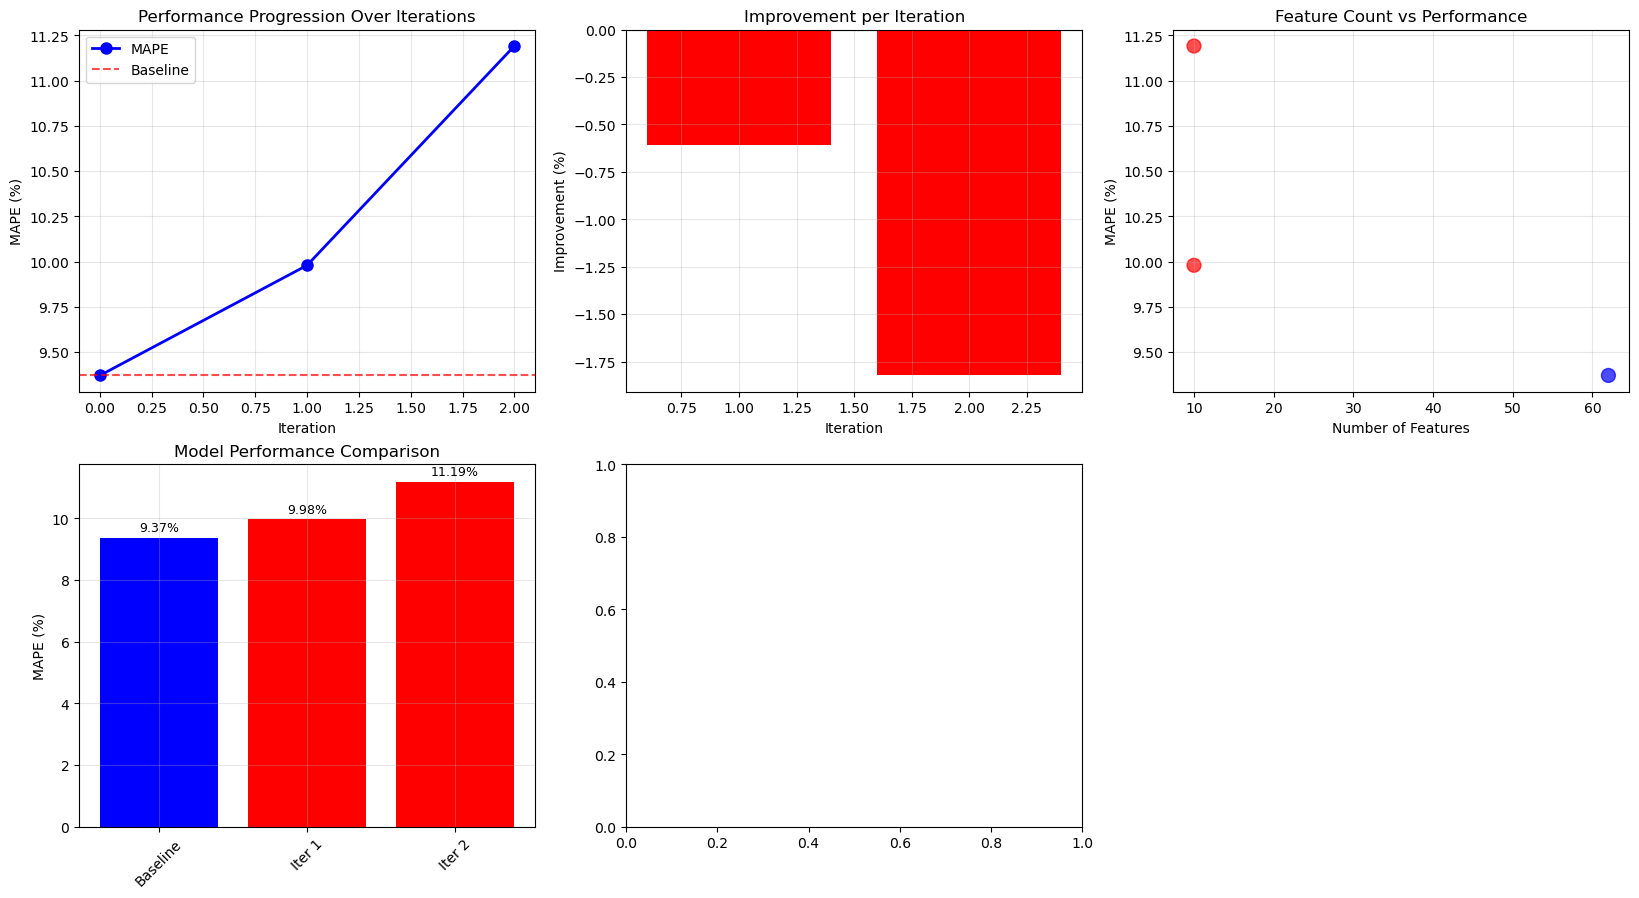

In [10]:
# Comprehensive Visualization
print("\n📊 Creating comprehensive visualizations...")

# Create a large figure with multiple subplots
fig = plt.figure(figsize=(20, 16))

# 1. Performance progression over iterations
plt.subplot(3, 3, 1)
iterations = [r['iteration'] for r in iteration_results]
mape_values = [r['mape'] for r in iteration_results]
improvements = [r['improvement'] for r in iteration_results]

plt.plot(iterations, mape_values, 'bo-', linewidth=2, markersize=8, label='MAPE')
plt.axhline(y=baseline_mape, color='r', linestyle='--', alpha=0.7, label='Baseline')
plt.xlabel('Iteration')
plt.ylabel('MAPE (%)')
plt.title('Performance Progression Over Iterations')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Improvement per iteration
plt.subplot(3, 3, 2)
plt.bar(iterations[1:], improvements[1:], color=['green' if imp > 0 else 'red' for imp in improvements[1:]])
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Improvement (%)')
plt.title('Improvement per Iteration')
plt.grid(True, alpha=0.3)

# 3. Feature count vs Performance
plt.subplot(3, 3, 3)
feature_counts = [r['feature_count'] for r in iteration_results]
colors = ['blue' if r['iteration'] == 0 else 'green' if r['improvement'] > 0 else 'red' for r in iteration_results]
plt.scatter(feature_counts, mape_values, c=colors, s=100, alpha=0.7)
plt.xlabel('Number of Features')
plt.ylabel('MAPE (%)')
plt.title('Feature Count vs Performance')
plt.grid(True, alpha=0.3)

# 4. Model comparison (bar chart)
plt.subplot(3, 3, 4)
model_names = [f"Iter {r['iteration']}" if r['iteration'] > 0 else "Baseline" for r in iteration_results]
bars = plt.bar(range(len(model_names)), mape_values, color=['blue'] + ['green' if imp > 0 else 'red' for imp in improvements[1:]])
plt.xticks(range(len(model_names)), model_names, rotation=45)
plt.ylabel('MAPE (%)')
plt.title('Model Performance Comparison')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, mape_values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{value:.2f}%', ha='center', va='bottom', fontsize=9)

# 5. True vs Predicted (Best Model)
plt.subplot(3, 3, 5)
best_predictions = best_result['predictions']
best_true = best_result['true_values']
plt.scatter(best_true, best_predictions, alpha=0.6, s=50)
plt.plot([best_true.min(), best_true.max()], [best_true.min(), best_true.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'True vs Predicted (Best Model: {best_result["model_name"]})')
plt.grid(True, alpha=0.3)

# 6. Time series comparison (Best Model vs Baseline)
plt.subplot(3, 3, 6)
test_range = range(len(best_true))
plt.plot(test_range, best_true, 'k-', linewidth=2, label='True', alpha=0.8)
plt.plot(test_range, baseline_results['predictions'], 'r-', linewidth=1.5, label='Baseline', alpha=0.7)
plt.plot(test_range, best_predictions, 'g-', linewidth=1.5, label='Best Model', alpha=0.7)
plt.xlabel('Test Sample')
plt.ylabel('Short Interest')
plt.title('Time Series Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# 7. Performance metrics comparison
plt.subplot(3, 3, 7)
metrics = ['MAPE', 'MAE', 'RMSE']
baseline_metrics = [baseline_results['mape'], baseline_results['mae']/1e6, baseline_results['rmse']/1e6]
best_metrics = [best_result['mape'], best_result['mae']/1e6, best_result['rmse']/1e6]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, baseline_metrics, width, label='Baseline', alpha=0.7)
plt.bar(x + width/2, best_metrics, width, label='Best Model', alpha=0.7)

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Metrics Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

# 8. Feature reduction efficiency
plt.subplot(3, 3, 8)
efficiency_data = []
for i, result in enumerate(iteration_results):
    if i == 0:
        efficiency_data.append(0)
    else:
        feature_red = ((baseline_features - result['feature_count']) / baseline_features) * 100
        performance_imp = result['improvement']
        efficiency_data.append(performance_imp / feature_red if feature_red > 0 else 0)

plt.bar(iterations[1:], efficiency_data[1:], color=['green' if eff > 0 else 'red' for eff in efficiency_data[1:]])
plt.xlabel('Iteration')
plt.ylabel('Efficiency (Improvement/Feature Reduction)')
plt.title('Feature Engineering Efficiency')
plt.grid(True, alpha=0.3)

# 9. Cumulative improvement
plt.subplot(3, 3, 9)
cumulative_improvement = [0]
for i in range(1, len(improvements)):
    cumulative_improvement.append(cumulative_improvement[-1] + improvements[i])

plt.plot(iterations, cumulative_improvement, 'go-', linewidth=2, markersize=6)
plt.xlabel('Iteration')
plt.ylabel('Cumulative Improvement (%)')
plt.title('Cumulative Performance Improvement')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualizations completed!")


In [12]:
best_result

{'iteration': 0,
 'model_name': 'Baseline',
 'features_used': 'All 62 original features',
 'feature_count': 62,
 'mape': 9.37122452950319,
 'mae': 7301369.571800289,
 'rmse': 9576693.442747284,
 'improvement': 0.0,
 'predictions': array([5.98582978e+07, 6.25753859e+07, 6.32193637e+07, 6.88554744e+07,
        7.44277183e+07, 6.76696088e+07, 7.09356428e+07, 6.51685841e+07,
        7.29543987e+07, 7.86932655e+07, 6.44571159e+07, 6.23853097e+07,
        5.81718256e+07, 6.80903418e+07, 6.44335470e+07, 6.81049717e+07,
        7.77457832e+07, 7.03057867e+07, 7.35728083e+07, 6.43618944e+07,
        9.73121123e+07, 9.28565211e+07, 8.79442305e+07, 7.82008106e+07,
        9.41288908e+07, 7.61428032e+07, 9.19527696e+07, 9.72672996e+07,
        1.00992702e+08, 9.89437720e+07, 1.09522500e+08, 1.16461063e+08,
        1.09032448e+08, 1.06534699e+08, 1.08311814e+08, 1.12926942e+08])}

In [11]:
# Save results and generate final report
print("\n💾 Saving results and generating final report...")

# Save iteration results to pickle
results_filename = f'cache/{stock}_iterative_results.pkl'
with open(results_filename, 'wb') as f:
    pickle.dump(iteration_results, f)

print(f"✅ Results saved to: {results_filename}")

# Generate detailed report
report_filename = f'cache/{stock}_iterative_report.txt'
with open(report_filename, 'w') as f:
    f.write("="*80 + "\n")
    f.write("ITERATIVE AGENT-BASED FEATURE SELECTION REPORT\n")
    f.write("="*80 + "\n")
    f.write(f"Stock: {stock}\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Total Iterations: {len(iteration_results) - 1}\n")
    f.write("\n")
    
    f.write("PERFORMANCE SUMMARY:\n")
    f.write("-" * 40 + "\n")
    f.write(f"Baseline MAPE: {baseline_mape:.2f}%\n")
    f.write(f"Best MAPE: {best_result['mape']:.2f}%\n")
    f.write(f"Total Improvement: {total_improvement:.2f}% ({improvement_percentage:.1f}% relative)\n")
    f.write(f"Feature Reduction: {feature_reduction:.1f}%\n")
    f.write(f"Success Rate: {efficiency:.1f}%\n")
    f.write("\n")
    
    f.write("DETAILED RESULTS:\n")
    f.write("-" * 40 + "\n")
    for result in iteration_results:
        f.write(f"Iteration {result['iteration']}: {result['model_name']}\n")
        f.write(f"  MAPE: {result['mape']:.2f}%\n")
        f.write(f"  Features: {result['feature_count']}\n")
        f.write(f"  Improvement: {result['improvement']:+.2f}%\n")
        f.write(f"  Source: {result.get('function_source', 'baseline')}\n")
        f.write("\n")
    
    f.write("BEST MODEL DETAILS:\n")
    f.write("-" * 40 + "\n")
    f.write(f"Model: {best_result['model_name']}\n")
    f.write(f"MAPE: {best_result['mape']:.2f}%\n")
    f.write(f"MAE: {best_result['mae']:.4f}\n")
    f.write(f"RMSE: {best_result['rmse']:.4f}\n")
    f.write(f"Features: {best_result['feature_count']}\n")
    f.write(f"Source: {best_result.get('function_source', 'baseline')}\n")
    
    if best_result.get('claude_code'):
        f.write("\nBEST MODEL FEATURE ENGINEERING CODE:\n")
        f.write("-" * 40 + "\n")
        f.write(best_result['claude_code'])

print(f"✅ Detailed report saved to: {report_filename}")

# Final summary
print("\n" + "="*70)
print("🎉 ITERATIVE AGENT-BASED FEATURE SELECTION COMPLETED!")
print("="*70)
print(f"📊 Final Results:")
print(f"   • Baseline MAPE: {baseline_mape:.2f}%")
print(f"   • Best MAPE: {best_result['mape']:.2f}%")
print(f"   • Total Improvement: {total_improvement:.2f}%")
print(f"   • Feature Reduction: {feature_reduction:.1f}%")
print(f"   • Iterations Completed: {len(iteration_results) - 1}")
print(f"   • Success Rate: {efficiency:.1f}%")
print(f"\n💾 Files Saved:")
print(f"   • Results: {results_filename}")
print(f"   • Report: {report_filename}")
print("\n✅ Process completed successfully!")



💾 Saving results and generating final report...
✅ Results saved to: cache/PFE_iterative_results.pkl
✅ Detailed report saved to: cache/PFE_iterative_report.txt

🎉 ITERATIVE AGENT-BASED FEATURE SELECTION COMPLETED!
📊 Final Results:
   • Baseline MAPE: 9.37%
   • Best MAPE: 9.37%
   • Total Improvement: 0.00%
   • Feature Reduction: 0.0%
   • Iterations Completed: 2
   • Success Rate: 0.0%

💾 Files Saved:
   • Results: cache/PFE_iterative_results.pkl
   • Report: cache/PFE_iterative_report.txt

✅ Process completed successfully!


In [32]:
def construct_features(data):
    """
    Constructs engineered features from raw financial data for short interest prediction.
    Input shape: (lookback_window, 62) where 62 = [short_interest, volume, OHLC_15days]
    Output shape: (lookback_window, constructed_features)
    """
    lookback = data.shape[0]

    # Initialize output array
    engineered = np.zeros((lookback, 25))

    for t in range(lookback):
        # Extract core features for current timestamp
        short_interest = data[t,0]
        volume = data[t,1]
        print(volume)

        # Reshape OHLC data (60 features) into (15,4) array
        ohlc = data[t,2:].reshape(15,4)
        opens = ohlc[:,0]
        highs = ohlc[:,1]
        lows = ohlc[:,2]
        closes = ohlc[:,3]

        # 1. Price momentum features
        returns = np.diff(closes) / closes[:-1]  # Daily returns
        engineered[t,0] = np.mean(returns)  # Average return
        engineered[t,1] = np.sum(returns > 0) / len(returns)  # Up day ratio

        # 2. Volatility features
        true_range = np.maximum(highs - lows,
                              np.abs(highs - np.roll(closes, 1)),
                              np.abs(lows - np.roll(closes, 1)))
        atr = np.mean(true_range)  # Average True Range
        engineered[t,2] = atr
        engineered[t,3] = np.std(returns)  # Return volatility

        # 3. Price level features
        typical_price = (highs + lows + closes) / 3
        engineered[t,4] = np.mean(typical_price)  # Average price
        engineered[t,5] = np.max(highs) / np.min(lows) - 1  # Price range

        # 4. Volume features
        vol_ma = np.mean(volume)  # Volume moving average
        engineered[t,6] = volume / vol_ma - 1  # Volume vs MA
        print(volume.shape)
        print(closes.shape)
        print(np.corrcoef(volume, closes))
        engineered[t,7] = np.corrcoef(volume, closes)[0,1]  # Volume-price correlation
        print(np.corrcoef(volume, closes)[0,1].shape)

        # 5. Short interest features
        engineered[t,8] = short_interest / volume  # Days to cover
        engineered[t,9] = short_interest / np.mean(closes)  # Short interest ratio

        # 6. Technical indicators
        # RSI
        gains = np.maximum(returns, 0)
        losses = np.abs(np.minimum(returns, 0))
        avg_gain = np.mean(gains)
        avg_loss = np.mean(losses)
        rs = avg_gain / (avg_loss + 1e-10)
        engineered[t,10] = 100 - (100 / (1 + rs))

        # MACD
        ema12 = np.mean(closes[-12:])
        ema26 = np.mean(closes[-26:]) if len(closes) >= 26 else ema12
        engineered[t,11] = ema12 - ema26

        # 7. Price patterns
        # Higher highs/lower lows
        engineered[t,12] = np.sum(np.diff(highs) > 0) / (len(highs)-1)
        engineered[t,13] = np.sum(np.diff(lows) < 0) / (len(lows)-1)

        # 8. Gap analysis
        gaps = opens - np.roll(closes, 1)
        engineered[t,14] = np.sum(gaps > 0) / (len(gaps)-1)  # Gap up ratio

        # 9. Candlestick patterns
        body = closes - opens
        upper_shadow = highs - np.maximum(opens, closes)
        lower_shadow = np.minimum(opens, closes) - lows
        engineered[t,15] = np.mean(body)  # Average body size
        engineered[t,16] = np.mean(upper_shadow)  # Average upper shadow
        engineered[t,17] = np.mean(lower_shadow)  # Average lower shadow

        # 10. Trend strength indicators
        sma20 = np.mean(closes[-20:]) if len(closes) >= 20 else np.mean(closes)
        engineered[t,18] = closes[-1] / sma20 - 1  # Price vs SMA

        # 11. Volatility regime
        engineered[t,19] = np.percentile(true_range, 75) / np.percentile(true_range, 25)

        # 12. Volume profile
        engineered[t,20] = np.corrcoef(volume, true_range)[0,1]  # Volume-volatility correlation

        # 13. Short interest momentum
        if t > 0:
            engineered[t,21] = short_interest / data[t-1,0] - 1

        # 14. Combined indicators
        engineered[t,22] = engineered[t,10] * engineered[t,6]  # RSI * Volume ratio
        engineered[t,23] = engineered[t,3] * engineered[t,8]  # Volatility * Days to cover
        engineered[t,24] = engineered[t,11] * engineered[t,9]  # MACD * Short ratio

    # Handle any NaN values
    return np.nan_to_num(engineered, nan=0.0)

In [35]:
x_test = np.zeros((142, 4,62))
x_test = x_test[:, -1, :]
x_test = x_test.reshape(x_test.shape[0], -1)
x_test.shape

(142, 62)

In [1]:
import pandas as pd

# Load the parquet file
df = pd.read_parquet('../data/price_data_multiindex_20250904_113138.parquet')

# Display basic info about the dataframe
print(df.head())
print(df.info())

                 A                                                      \
           1. open 2. high 3. low 4. close 5. adjusted close 6. volume   
1999-11-01     NaN     NaN    NaN      NaN               NaN       NaN   
1999-11-02     NaN     NaN    NaN      NaN               NaN       NaN   
1999-11-03     NaN     NaN    NaN      NaN               NaN       NaN   
1999-11-04     NaN     NaN    NaN      NaN               NaN       NaN   
1999-11-05     NaN     NaN    NaN      NaN               NaN       NaN   

                                                     KMTUF          ...  \
           7. dividend amount 8. split coefficient 1. open 2. high  ...   
1999-11-01                NaN                  NaN     NaN     NaN  ...   
1999-11-02                NaN                  NaN     NaN     NaN  ...   
1999-11-03                NaN                  NaN     NaN     NaN  ...   
1999-11-04                NaN                  NaN     NaN     NaN  ...   
1999-11-05                NaN  

In [4]:
all_tickers = set([x[0] for x in df.columns])
len(all_tickers)

5818

In [39]:
# Get the first level of column names
first_level = df.columns.get_level_values(0)
print(first_level)

# If you want unique values only
unique_tickers = df.columns.get_level_values(0).unique()
print(unique_tickers)

Index(['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'KMTUF', 'KMTUF',
       ...
       'BST', 'BST', 'EGP', 'EGP', 'EGP', 'EGP', 'EGP', 'EGP', 'EGP', 'EGP'],
      dtype='object', length=46544)
Index(['A', 'KMTUF', 'KNYJF', 'KNX', 'KNSL', 'KNOP', 'KNNGF', 'KNKZF', 'KNDI',
       'KNCRF',
       ...
       'BSRR', 'AWK', 'AXGN', 'BRID', 'ASND', 'EBAY', 'DOGZ', 'DXR', 'BST',
       'EGP'],
      dtype='object', length=5818)
